In [38]:
import numpy as np
import tensorflow as tf
from datetime import datetime
from IPython.display import HTML
from node.core import get_node_function
from node.fix_grid import RKSolver
from node.utils.trajectory import tracer, visualize_trajectory
from node.energy_based import Energy, energy_based, identity


# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)


class MyLayer(tf.keras.layers.Layer):

    def __init__(self, units, dt, num_grids, **kwargs):
        super().__init__(**kwargs)
        self.dt = dt
        self.num_grids = num_grids

        t0 = tf.constant(0., dtype=DTYPE)
        self.tN = t0 + num_grids * dt

        self._model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu', dtype=DTYPE),
            tf.keras.layers.Dense(units, dtype=DTYPE),
        ])
        self._model.build([None, units])

        self._raw_pvf = lambda _, x: self._model(x)
        self._pvf = energy_based(identity, identity, self._raw_pvf)
        self._node_fn = get_node_function(RKSolver(self.dt, dtype=DTYPE),
                                          tf.constant(0., dtype=DTYPE),
                                          self._pvf)
                                          # self._raw_pvf)  # for comparison.

    def call(self, x):
        y = self._node_fn(self.tN, x)
        return y

    def get_config(self):
        return super().get_config().copy()


def process(X, y):
    X = X / 255.
    X = tf.reshape(X, [-1, 28 * 28])
    y = tf.one_hot(y, 10)
    return tf.cast(X, DTYPE), tf.cast(y, DTYPE)


mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = process(x_train, y_train)
x_test, y_test = process(x_test, y_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input([28 * 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    MyLayer(64, dt=1e-1, num_grids=10),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(1e-3),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=12, batch_size=128)

Train on 60000 samples
Epoch 1/12
60000/60000 [==============================] - 33s 558us/sample - loss: 0.3167 - accuracy: 0.9059
Epoch 2/12
60000/60000 [==============================] - 32s 532us/sample - loss: 0.1660 - accuracy: 0.9498
Epoch 3/12
60000/60000 [==============================] - 32s 533us/sample - loss: 0.1591 - accuracy: 0.9520
Epoch 4/12
60000/60000 [==============================] - 31s 523us/sample - loss: 0.1239 - accuracy: 0.9623
Epoch 5/12
60000/60000 [==============================] - 32s 529us/sample - loss: 0.1079 - accuracy: 0.9664
Epoch 6/12
60000/60000 [==============================] - 32s 541us/sample - loss: 0.0982 - accuracy: 0.9692
Epoch 7/12
60000/60000 [==============================] - 32s 530us/sample - loss: 0.0889 - accuracy: 0.9724
Epoch 8/12
60000/60000 [==============================] - 32s 528us/sample - loss: 0.0869 - accuracy: 0.9726
Epoch 9/12
60000/60000 [==============================] - 37s 612us/sample - loss: 0.0793 - accuracy: 0.9

In [39]:
longer_trajectory_model = tf.keras.Sequential([
    tf.keras.layers.Input([28 * 28]),
    tf.keras.layers.BatchNormalization(),  # input stardarization.
    tf.keras.layers.Dense(64),
    MyLayer(64, dt=1e-1, num_grids=20),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

longer_trajectory_model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'])

longer_trajectory_model.set_weights(model.get_weights())
longer_trajectory_model.evaluate(x_train, y_train, batch_size=128)

ValueError: You called `set_weights(weights)` on layer "sequential_17" with a weight list of length 20, but the layer was expecting 16 weights. Provided weights: [array([1.        , 1.        , 1.        , 1.    ...

In [24]:
model.layers

In [35]:
my_layer_id = 2
my_layer = model.layers[my_layer_id]
trace = tracer(RKSolver(0.1), my_layer._pvf)
energy_fn = Energy(identity, my_layer._pvf)

truncated_model = tf.keras.Sequential(model.layers[:my_layer_id])
hidden = truncated_model(x_train[:100])
labels = y_train[:100]
trajectory = trace(t0=tf.constant(0.),
                   t1=tf.constant(10.),
                   dt=tf.constant(0.1),
                   x=hidden)
trajectory = tf.stack([model.layers[3](_) for _ in tf.unstack(trajectory, axis=1)], axis=1)

def energy_along_trajectory(trajectory):
    shape = trajectory.get_shape().as_list()
    batch_size, trajectory_size, *phase_dims = shape
    phase_points = tf.reshape(trajectory, [-1, *phase_dims])
    e = energy_fn(phase_points)
    return tf.reshape(e, [batch_size, trajectory_size])


energy = energy_along_trajectory(trajectory)

In [36]:
trajectory.shape

TensorShape([100, 101, 64])

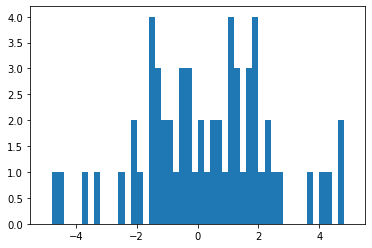

In [13]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


i = 11
diffs = (trajectory[:,-1,:] - trajectory[:,0,:])
plt.hist(diffs[i], bins=50, range=(-5, 5))
plt.show()

In [14]:
labels_ = np.argmax(labels.numpy(), -1)
print(list(enumerate(labels_)))

[(0, 5), (1, 0), (2, 4), (3, 1), (4, 9), (5, 2), (6, 1), (7, 3), (8, 1), (9, 4), (10, 3), (11, 5), (12, 3), (13, 6), (14, 1), (15, 7), (16, 2), (17, 8), (18, 6), (19, 9), (20, 4), (21, 0), (22, 9), (23, 1), (24, 1), (25, 2), (26, 4), (27, 3), (28, 2), (29, 7), (30, 3), (31, 8), (32, 6), (33, 9), (34, 0), (35, 5), (36, 6), (37, 0), (38, 7), (39, 6), (40, 1), (41, 8), (42, 7), (43, 9), (44, 3), (45, 9), (46, 8), (47, 5), (48, 9), (49, 3), (50, 3), (51, 0), (52, 7), (53, 4), (54, 9), (55, 8), (56, 0), (57, 9), (58, 4), (59, 1), (60, 4), (61, 4), (62, 6), (63, 0), (64, 4), (65, 5), (66, 6), (67, 1), (68, 0), (69, 0), (70, 1), (71, 7), (72, 1), (73, 6), (74, 3), (75, 0), (76, 2), (77, 1), (78, 1), (79, 7), (80, 9), (81, 0), (82, 2), (83, 6), (84, 7), (85, 8), (86, 3), (87, 9), (88, 0), (89, 4), (90, 6), (91, 7), (92, 4), (93, 6), (94, 8), (95, 0), (96, 7), (97, 8), (98, 3), (99, 1)]


In [15]:
def visualize(trajectory, label):
    print(f'label: {label}')
    anim = visualize_trajectory(trajectory.reshape([-1, 8, 8]))
    return HTML(anim.to_html5_video())

label: 5


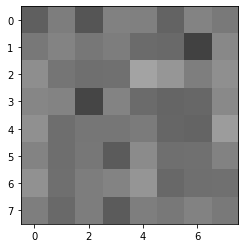

In [27]:
i = 0
visualize(trajectory.numpy()[i], labels_[i])

label: 5


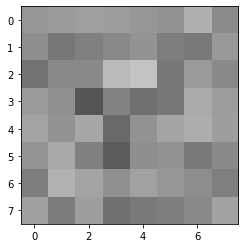

In [17]:
i = 11
visualize(trajectory.numpy()[i], labels_[i])

label: 5


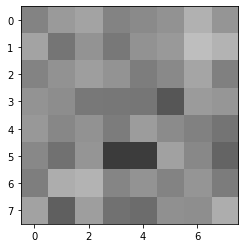

In [18]:
i = 35
visualize(trajectory.numpy()[i], labels_[i])

label: 6


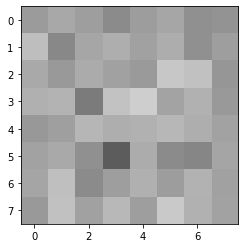

In [19]:
i = 36
visualize(trajectory.numpy()[i], labels_[i])

label: 0


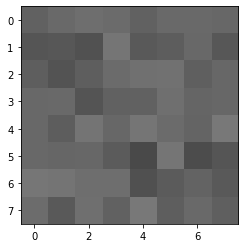

In [20]:
i = 37
visualize(trajectory.numpy()[i], labels_[i])

In [29]:
diffs = trajectory[:, 1:, :] - trajectory[:, :-1, :]

In [34]:
diffs[0, :, 50]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([-2.35295   , -1.058902  , -0.49699378, -0.13993335, -0.12291789,
       -0.2195208 , -0.1797893 , -0.15420175, -0.1191349 , -0.04428172,
       -0.06976724, -0.05351567, -0.05785871, -0.05351663, -0.0615623 ,
       -0.04243875, -0.04962182, -0.05653214, -0.04696536, -0.05169439,
       -0.02283001, -0.02213764, -0.01972461, -0.02526784, -0.02676296,
       -0.02367473, -0.0231421 , -0.02498913, -0.02225852, -0.02316499,
       -0.02403331, -0.02142024, -0.02547669, -0.01919365, -0.02335286,
       -0.02158046, -0.01652074, -0.01764965, -0.01935244, -0.01742601,
       -0.01712322, -0.01883984, -0.01474547, -0.01820755, -0.01551819,
       -0.0159905 , -0.01711035, -0.01559424, -0.01454753, -0.01450694,
       -0.01482689, -0.01244974, -0.01413476, -0.01218164, -0.01243246,
       -0.0142318 , -0.01141572, -0.01415169, -0.01112556, -0.01351094,
       -0.01579881, -0.01138508, -0.01595998, -0.01068985, -0.00999093,
       -0.011160

In [22]:
variance[10]

<tf.Tensor: shape=(101,), dtype=float32, numpy=
array([7.2862024 , 3.4536977 , 2.5136447 , 2.0751352 , 1.9365419 ,
       1.8305765 , 1.692567  , 1.5914711 , 1.5103495 , 1.4464309 ,
       1.4174287 , 1.3676916 , 1.3282349 , 1.2968976 , 1.2718958 ,
       1.2501831 , 1.2304258 , 1.2109363 , 1.1895227 , 1.1699619 ,
       1.1524954 , 1.1432769 , 1.1355686 , 1.1265223 , 1.1183686 ,
       1.1101878 , 1.1034758 , 1.0960726 , 1.0896747 , 1.083705  ,
       1.0773542 , 1.0709577 , 1.0647377 , 1.0594413 , 1.0550516 ,
       1.0502324 , 1.0453533 , 1.0408875 , 1.0359225 , 1.030841  ,
       1.0262984 , 1.0215867 , 1.0171396 , 1.0135673 , 1.0091999 ,
       1.0051168 , 1.0009053 , 0.99724865, 0.993659  , 0.990744  ,
       0.9873815 , 0.9848342 , 0.9816098 , 0.9788617 , 0.9761783 ,
       0.97329086, 0.97065383, 0.9675016 , 0.96552074, 0.96274656,
       0.9602581 , 0.9576299 , 0.95576096, 0.9525312 , 0.9503951 ,
       0.94809985, 0.9456245 , 0.94295454, 0.94120044, 0.9384992 ,
       0.93633

## Conclusion

### Training

1. The standarization of inputs, by adding a batch normalization layer directly after the input layer, is essential. Otherwise, the energy based model, comparing to the non-energy based model with the same architecture, will gain a much lower accuracy (96% comparing to 99%). In addition, without the batch normalization layer, the training process will be far from numeric stable; learning rate `1e-3` will cause NaN problem. Adding single batch normalization layer will, however, make the training smooth with high learning rate.

1. Attractors may cause gradient exploding. $\partial L / \partial \theta = - \int_{t_1}^{t_0} \partial L / \partial z^{\alpha}(t) \partial f^{\alpha} / \partial \theta \left(z(t)\right)$, attractor from $t > t_0$ to $t_1$ leads to a constant integrand within interval $[t, t_1]$, thus accumulating the gradient linearly. Then, a long interval of attraction may cause large gradient. An adaptive time interval may rescure this situation.

1. An additional batch normalization layer directly after NODE layer is essential, as well as sufficient, for numerical stability for dtype "float32". For dtype "float64", the situation is invariant. This numerical instability (when without batch normalization) may be duing to the previous note.